# <center> Predição de Potenciais Clientes </center>

### Bibliotecas Utilizadas

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score, precision_score,recall_score, f1_score, classification_report, roc_curve, auc

### Consumo de base e definição de features

In [133]:
base_forms = pd.read_excel("./Praceando.xlsx")
base_forms.shape

(92, 20)

### Tratamento das Features

##### Removendo Features Redundantes

In [134]:
base_forms[["Você mora na cidade de São Paulo","Em que zona da cidade de São Paulo você mora?"]].value_counts()

Você mora na cidade de São Paulo  Em que zona da cidade de São Paulo você mora?
Sim                               Oeste                                            44
                                  Norte                                            23
                                  Sul                                               5
                                  Leste                                             4
                                  Centro                                            2
Name: count, dtype: int64

In [135]:
base_forms = base_forms.drop(["Hora de início","Hora de conclusão","Email","Nome","Você mora na cidade de São Paulo","Deixe seu e-mail para ser notificado!"],axis=1)

##### Renomenando Features

In [136]:

base_forms= base_forms.rename(columns={
    "Qual é a sua faixa etária?":"faixa_etaria",
    "Em que zona da cidade de São Paulo você mora?":"regiao",
    "Você costuma organizar ou participar de eventos em praças e parques?":"tipo_usuario",
    "Você encontra dificuldade em divulgar seus eventos?":"dificuldade_divulgacao",
    "Você tem dificuldade em encontrar eventos?":"difuculdade_participacao",
    "Você se considera um microempreendedor?":"is_microempreendedor",
    "Como você costuma divulgar seus eventos atualmente? (Selecione todas as opções que se aplicam)":"meios_divulgacao",
    "Com que frequência você organiza eventos em espaços públicos como praças e parques?":"frequencia_divulgacao",
    "Qual seria a sua disposição para pagar um valor simbólico para anunciar seus eventos em um aplicativo especializado em praças e parques?":"pagar_divulgacao",
    "Se você utiliza ou utilizaria um aplicativo para promover seus eventos, qual das seguintes funcionalidades seria mais útil para você?":"funcionalidades_divulgacao",
    "Que tipo de evento você organiza ou participaria em praças ou parques (Selecione todos que se aplicam)":"interesse_eventos",
    "Quais fatores são mais importantes para você na escolha de um aplicativo de divulgação de eventos?":"fatores_app",
    "Você gostaria de ser notificado quando o aplicativo Praceando expandir sua atuação para novas regiões ou oferecer novas funcionalidades?":"receber_notificacao"
})

##### Tratamento de Nulos e Nans

In [137]:
base_forms["regiao"] = base_forms["regiao"].fillna("N/A Regiao")
base_forms["dificuldade_divulgacao"] = base_forms["dificuldade_divulgacao"].fillna("Não")
base_forms["difuculdade_participacao"] = base_forms["difuculdade_participacao"].fillna("Não")
base_forms["is_microempreendedor"] = base_forms["is_microempreendedor"].fillna("Não")
base_forms["meios_divulgacao"] = base_forms["meios_divulgacao"].fillna("Não costumo divulgar")
base_forms["frequencia_divulgacao"] = base_forms["frequencia_divulgacao"].fillna("Não costumo divulgar")
base_forms["pagar_divulgacao"] = base_forms["pagar_divulgacao"].fillna("Não pagaria")
base_forms["funcionalidades_divulgacao"] = base_forms["funcionalidades_divulgacao"].fillna("N/A Funcionalidades")

##### Tratamento personalizado

In [138]:
for i in base_forms.columns:
    base_forms[i] = base_forms[i].apply(lambda x: x.lower().strip() if type(x)==str else x)

base_forms["meios_divulgacao"] = base_forms["meios_divulgacao"].apply(lambda x: x[:-1].lower().replace(" ","_").split(";") if x.split(";")[-1]=="" else x.lower().replace(" ","_").split(";"))
base_forms = base_forms.explode("meios_divulgacao")
base_forms["meios_divulgacao"] = base_forms["meios_divulgacao"].replace({"não_costumo_divulga":"não_costumo_divulgar","redes_sociais_(instagram,_facebook,_etc.)":"redes_sociais"})
base_forms = base_forms.drop(["funcionalidades_divulgacao","interesse_eventos","fatores_app"],axis=1)
  

In [139]:
base_forms = pd.get_dummies(base_forms, columns=["meios_divulgacao"])
base_forms_pre = base_forms.copy()

In [140]:
base_forms_pre["faixa_etaria"] = base_forms_pre["faixa_etaria"].map({'menor que 18 anos':45,'entre 30 e 59 anos':45,'entre 18 e 30 anos':6,'mais que 60 anos':6})
base_forms_pre["regiao"] = base_forms_pre["regiao"].map({'oeste':3,'norte':3,'leste':3,'n/a regiao':0, 'centro':3, 'sul':3})
base_forms_pre["tipo_usuario"] = base_forms_pre["tipo_usuario"].map({'participo de eventos':100,'nenhum':-15,'ambos':80,'organizo eventos':45})
base_forms_pre["dificuldade_divulgacao"] = base_forms_pre["dificuldade_divulgacao"].map({'sim':80,'não':18})
base_forms_pre["difuculdade_participacao"] = base_forms_pre["difuculdade_participacao"].map({'sim':45,'não':9})
base_forms_pre["is_microempreendedor"] = base_forms_pre["is_microempreendedor"].map({'não':9,'sim':18})
base_forms_pre["meios_divulgacao_boca_a_boca"] = base_forms_pre["meios_divulgacao_boca_a_boca"].map({True:9,False:0})
base_forms_pre["meios_divulgacao_não_costumo_divulgar"] = base_forms_pre["meios_divulgacao_não_costumo_divulgar"].map({True:-3,False:0})
base_forms_pre["meios_divulgacao_panfletos/flyers"] = base_forms_pre["meios_divulgacao_panfletos/flyers"].map({True:9,False:0})
base_forms_pre["meios_divulgacao_redes_sociais"] = base_forms_pre["meios_divulgacao_redes_sociais"].map({True:27,False:0})
base_forms_pre["meios_divulgacao_sites_ou_blogs"] = base_forms_pre["meios_divulgacao_sites_ou_blogs"].map({True:27,False:0})                                                                                         
base_forms_pre["frequencia_divulgacao"] = base_forms_pre["frequencia_divulgacao"].map({'não costumo divulgar':-3,'raramente (1-2 vezes por ano)':18,'ocasionalmente (3-6 vezes por ano)':27,'frequentemente (7 ou mais vezes por ano)':45})
base_forms_pre["pagar_divulgacao"] = base_forms_pre["pagar_divulgacao"].map({'com certeza pagaria':27,'pagaria dependendo do valor':18,'não pagaria':9})
base_forms_pre["receber_notificacao"] = base_forms_pre["receber_notificacao"].map({'não':9,'sim':75})

			

In [141]:
base_forms_pre = base_forms_pre.drop_duplicates(keep="first")

### Clusterização

##### Aplicando PCA

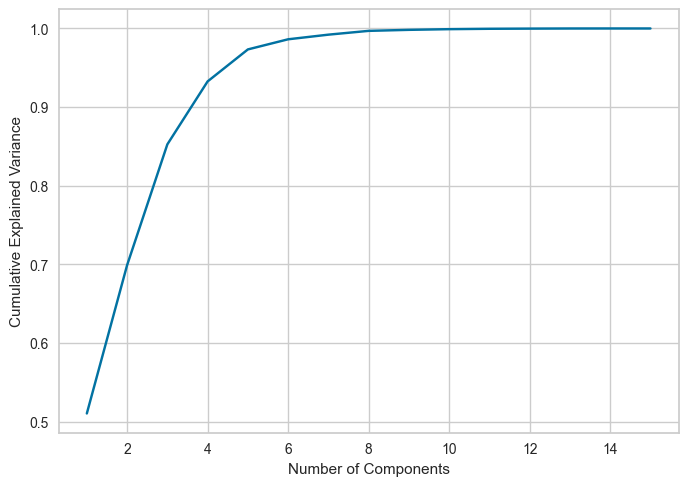

In [142]:
pca = PCA().fit(base_forms_pre)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


##### Quantidade de Clusters

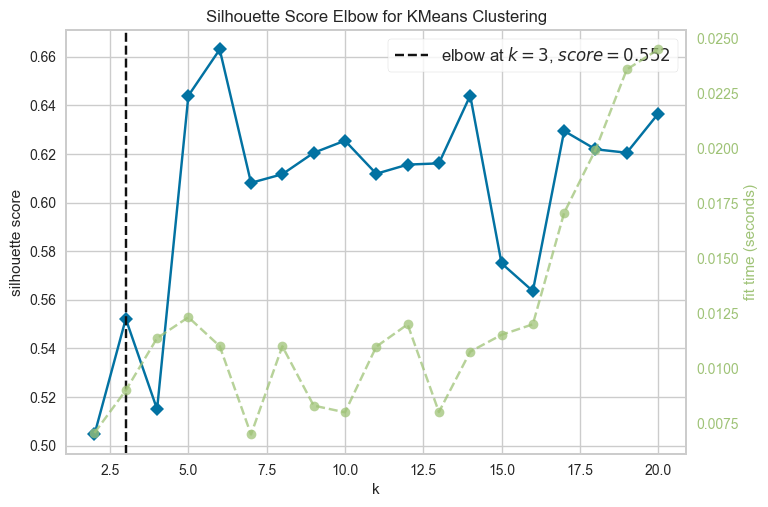

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [143]:
pca = PCA(n_components=3)
base_forms_pca = pca.fit_transform(base_forms_pre)
base_forms_pca = pd.DataFrame(base_forms_pca, columns=[f"PCA{i+1}" for i in range(3)])

model = KMeans()
visualizer = KElbowVisualizer(model, k=20, metric="silhouette", distance_metric='euclidean')
visualizer.fit(base_forms_pca)
visualizer.show()

In [159]:
from sklearn.cluster import KMeans

modelo = KMeans(n_clusters =6, random_state=42, n_init="auto", algorithm='elkan', max_iter=500)

base_forms_pca = pd.DataFrame(base_forms_pca, columns=[f"PCA{i+1}" for i in range(3)])
modelo.fit(base_forms_pca)

centers = modelo.cluster_centers_  

labels = modelo.labels_

print(labels)

[2 2 3 0 2 0 3 1 1 5 0 3 3 5 0 5 0 0 5 0 0 0 0 5 3 5 1 1 3 0 0 3 3 5 2 0 0
 5 0 2 2 2 2 5 2 5 3 2 5 1 3 1 2 2 4 4 2 3 0 3 0 0 0 3 3 2 2 0 2 1 1 3 3 2
 0 3 0 1 1 0 2 4 4 0 0 2 3 2 2 2 0 4 4 4 4 4 4 4]


In [160]:

base_forms['Cluster'] = labels
cluster_0 = base_forms.loc[base_forms['Cluster'] == 0]
cluster_1 = base_forms.loc[base_forms['Cluster'] == 1]
cluster_2 = base_forms.loc[base_forms['Cluster'] == 2]
cluster_3 = base_forms.loc[base_forms['Cluster'] == 3]
cluster_4 = base_forms.loc[base_forms['Cluster'] == 4]
cluster_5 = base_forms.loc[base_forms['Cluster'] == 5]
cluster_6 = base_forms.loc[base_forms['Cluster'] == 6]
cluster_7 = base_forms.loc[base_forms['Cluster'] == 7]



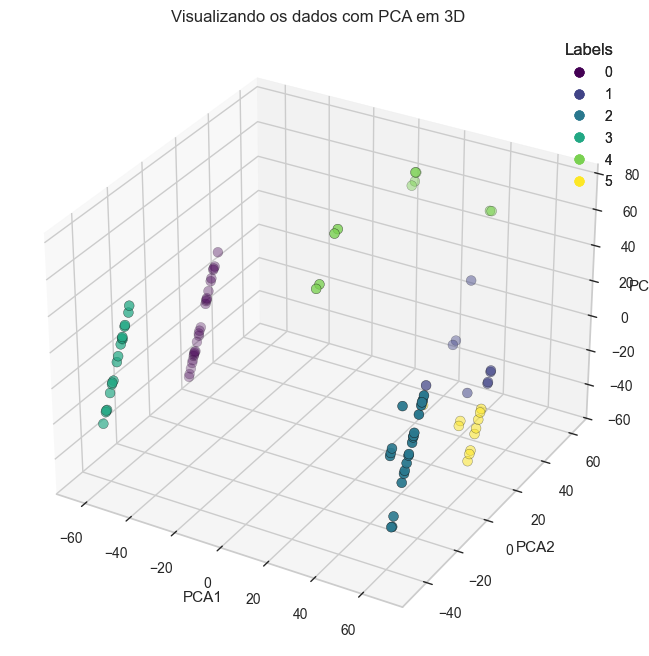

In [161]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importa o módulo para gráficos 3D

# Configura a figura em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Cria o scatter plot em 3D com os três eixos PCA
scatter = ax.scatter(
    base_forms_pca['PCA1'],  # Eixo X
    base_forms_pca['PCA2'],  # Eixo Y
    base_forms_pca['PCA3'],  # Eixo Z
    c=labels,                # Colore pelos labels
    edgecolor='k', 
    s=50, 
    cmap='viridis'
)

# Configura os rótulos dos eixos
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Visualizando os dados com PCA em 3D')

# Adiciona a legenda
legend = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend)

plt.show()


In [168]:
cluster_4.value_counts()

Id  faixa_etaria        regiao      tipo_usuario      dificuldade_divulgacao  difuculdade_participacao  is_microempreendedor  frequencia_divulgacao                     pagar_divulgacao             receber_notificacao  meios_divulgacao_boca_a_boca  meios_divulgacao_não_costumo_divulgar  meios_divulgacao_panfletos/flyers  meios_divulgacao_redes_sociais  meios_divulgacao_sites_ou_blogs  Cluster
53  entre 30 e 59 anos  norte       organizo eventos  sim                     não                       sim                   ocasionalmente (3-6 vezes por ano)        pagaria dependendo do valor  não                  False                         False                                  False                              True                            False                            4          1
                                                                                                                                                                                                             

In [171]:
cluster_1.value_counts()    


Id  faixa_etaria        regiao      tipo_usuario          dificuldade_divulgacao  difuculdade_participacao  is_microempreendedor  frequencia_divulgacao               pagar_divulgacao             receber_notificacao  meios_divulgacao_boca_a_boca  meios_divulgacao_não_costumo_divulgar  meios_divulgacao_panfletos/flyers  meios_divulgacao_redes_sociais  meios_divulgacao_sites_ou_blogs  Cluster
8   entre 30 e 59 anos  n/a regiao  ambos                 sim                     não                       não                   raramente (1-2 vezes por ano)       pagaria dependendo do valor  sim                  False                         False                                  False                              True                            False                            1          1
                                                                                                                                                                                                                 

In [175]:
cluster_5.value_counts()

Id  faixa_etaria        regiao      tipo_usuario          dificuldade_divulgacao  difuculdade_participacao  is_microempreendedor  frequencia_divulgacao               pagar_divulgacao             receber_notificacao  meios_divulgacao_boca_a_boca  meios_divulgacao_não_costumo_divulgar  meios_divulgacao_panfletos/flyers  meios_divulgacao_redes_sociais  meios_divulgacao_sites_ou_blogs  Cluster
9   entre 30 e 59 anos  oeste       ambos                 não                     não                       não                   ocasionalmente (3-6 vezes por ano)  pagaria dependendo do valor  sim                  False                         False                                  False                              True                            False                            5          1
13  entre 30 e 59 anos  n/a regiao  participo de eventos  não                     sim                       não                   não costumo divulgar                não pagaria                  sim           